# Inference: Slice Sampling with Doubling
This example shows you how to perform Bayesian inference on multiple toy problems, using
Slice Sampling with Doubling, as described in [1].

This is a univariate method, which is applied in a Slice-Sampling-within-Gibbs framework to allow MCMC sampling from multivariate models. It generates samples by sampling uniformly from the volume underneath the posterior ($f$). It does so by introducing an auxiliary variable ($y$) and by definying a Markov chain.

If the distribution is univariate, sampling follows:

1. Calculate the pdf ($f(x_0)$) of the current sample ($x_0$).
2. Draw a real value ($y$) uniformly from ($0, f(x_0)$), defining a horizontal “slice”: $S = {x: y < f (x)}$. Note that $x_0$ is always within $S$.
3. Find an interval ($I = (L, R)$) around $x_0$ that contains all, or much, of the slice.
4. Draw a new point ($x_1$) from the part of the slice within this interval.

If the distribution is multivariate, we apply the univariate algorithm to each variable in turn, where the other variables are set at their current values.

In this notebook, we use the Doubling procedure to estimate the interval $I$: we expand the initial interval by producing a sequence of intervals, each twice the size of the previous one, until an interval is found with both ends outside the slice, or until a predetermined limit is reached.

[1] Neal, R.M., 2003. Slice sampling. The annals of statistics, 31(3),
    pp.705-767.

# Problem 1: Unimodal Gaussian Distribution
First, we create our target Gaussian distribution.

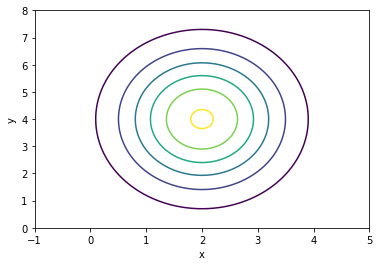

In [32]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up a sampling routine using Slice Sampling with Doubling.

In [4]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceDoublingMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

We now set the hyperparameters of the sampler:

1. The expansion steps width.
2. The limit of expansion steps allowed.

These parameters limit the size of the interval $I$ to ``(2^expansion_steps) * w``. Interestingly, not much tuning is needed for setting such hyperparameters: as long as we have a vague estimation of the typical size of a slice, we can set ``(2^expansion_steps) * w`` to be equal to this guess. In this example, we set ``expansion_steps = 10``, with ``width = 0.01`` to allow a more granular but expensive expansion.

In [5]:
for sampler in mcmc.samplers():
    sampler.set_width([0.01, 0.01])
    sampler.set_expansion_steps(10)
    
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     159     0:00.0
2     324     0:00.0
3     483     0:00.0
1000  156513   0:04.1
2000  312222   0:08.0
Halting: Maximum number of iterations (2000) reached.
Done!


We then use Pints' [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html) to investigate the performance of the sampler.

We start by using the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) to see if the 3 chains have converged to the same solution.

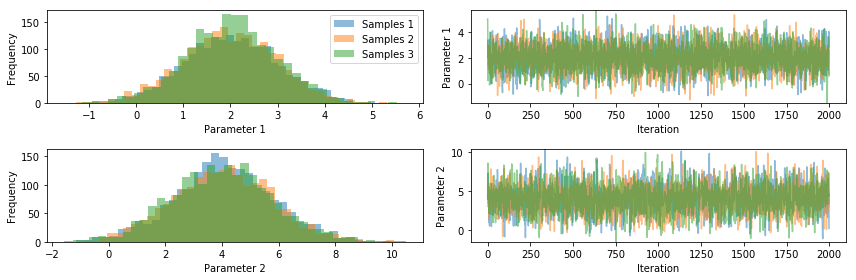

In [6]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after only a few iterations, and preserve a similar behaviour for the remaining iterations. To further investigate convergence, we can use the R-hat criterion, which is based on the stability of outcomes between and within chains of the same length. If everything went well, we should expect values close to 1.

In [7]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

R-hat:
[1.0002373520796364, 1.0003907923191186]


As we can see, the chains converge to the same underlying distribution!

We can now continue our analysis by considering the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method for the first chain.

In [8]:
chain = full_chains[0]

If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

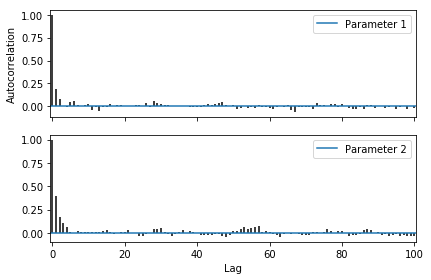

In [9]:
pints.plot.autocorrelation(chain)
plt.show()

We can now look at the correlation between the different parameters by using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

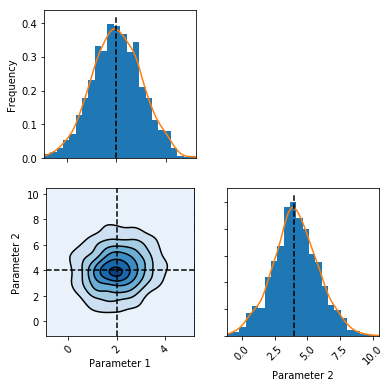

In [10]:
pints.plot.pairwise(chain, kde=True, ref_parameters=[2,4])
plt.show()

From the plots, we can see that we reach the original "true" values of the target posterior, and that the method suggests a normal distribution around the correct mean!

Finally, as our target distribution is Gaussian, we can calculate analytically the KL divergence between the distributions obtained from the chains and the true posterior distribution. We would expect the KL values to be be approximately $0$ to indicate no loss of information between the distributions.

In [11]:
# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(full_chains[0]))
print(log_pdf.kl_divergence(full_chains[1]))
print(log_pdf.kl_divergence(full_chains[2]))

0.00437538156602324
0.0009805529871242946
0.0021342283640952697


# Problem 2: Multimodal Distribution

Having the confidence that Slice Sampling with Doubling performs well on a simple unimodal Gaussian distribution, we check its performance on a more problematic multimodal exercise.

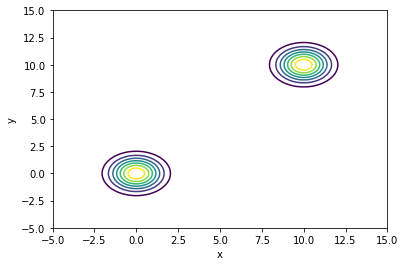

In [12]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.MultimodalGaussianLogPDF()

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As the two modes are not aligned along any axis direction, and since Slice Sampling updates each variable in turn along one axis, we would expect this problem to possibly cause the sampler to get stuck around one mode.

To check the performance, we create 4 chains with random initial points between $[2, 2]$ and $[8, 8]$.

In [13]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceDoublingMCMC)

for sampler in mcmc.samplers():
    sampler.set_width(5)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)
mcmc.set_log_interval(1000)

# Disable logging
mcmc.set_log_to_screen(True)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Doubling
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     4       0:00.0
1     140     0:00.0
2     232     0:00.0
3     316     0:00.0
1000  80864   0:04.5
2000  160563   0:08.5
Halting: Maximum number of iterations (2000) reached.
Done!


We now plot the samples against the contour curves of the target distribution.

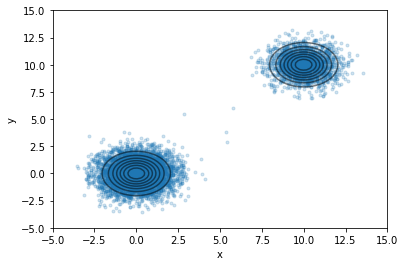

In [14]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Interestingly, the sampler doesn't get stuck around one mode, and manages to explore efficiently the parameter space. However, this outcome depends on the location of the initial points, and on the stochastic steps acting within the sampler which determine the location of the intervals from which we draw a new sample during each MCMC step. As a result, we should expect Slice Sampling with Doubling chains to sometimes get stuck.

To check the quality of the distribution obtained from the samples, we calculate the KL divergence from the original multimodal target.

In [15]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.00306184 0.00107615]


The KL values for both modes are approximately $0$, showing no loss of information.

# Problem 3: 3 Modes Multimodal Gaussian

To test whether our previous hypothesis concerning whether the Slice Sampling sampler sometimes gets stuck when the target modes are not axis-aligned, we create a new problem with 3 non-axis-aligned modes.

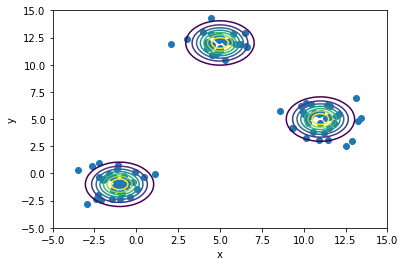

In [35]:
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[-1, -1], [11, 5], [5, 12]])

samples = log_pdf.sample(100)

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [60]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [5, 5], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceDoublingMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


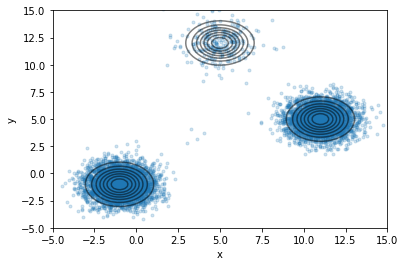

In [61]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As expected, one of the modes has hardly been explored. However, increasing the inverval from which we draw the initial chain samples allows to overcome this issue.

The KL divergence should be very good for two modes, and obviously terrible for the poorly-explored one.

In [63]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.00070917 0.0006258  0.07273193]


# Problem 4: Time-Series Problem - Logistic Model
We now try the same method on a more realistic time-series problem using a logistic model, following the tutorial notebook: [sampling-first-example](./sampling-first-example.ipynb).

In [24]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceDoublingMCMC)
    
# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(500)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     222     0:00.0
2     378     0:00.0
3     555     0:00.0
500   50622   0:03.6
1000  101208   0:07.3
1500  151764   0:10.8
2000  200989   0:14.1
Halting: Maximum number of iterations (2000) reached.
Done!


As done for the previous unimodal Gaussian example, we use Pints' trace tool to check convergence.

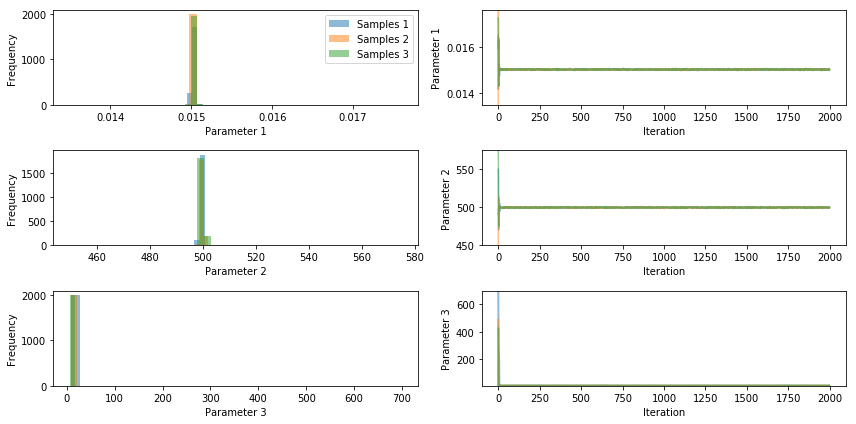

In [25]:
# Show traces and histograms
pints.plot.trace(full_chains)
plt.show()

From the plots we can see that the chains rapidly converge towards the same values after a few iterations.

To further investigate convergence, we use the R-hat criterion.

In [26]:
# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

R-hat:
[0.9997793835411939, 0.9999260508379426, 0.9999426854007625]


Finally, we look at the correlation between different parameters.

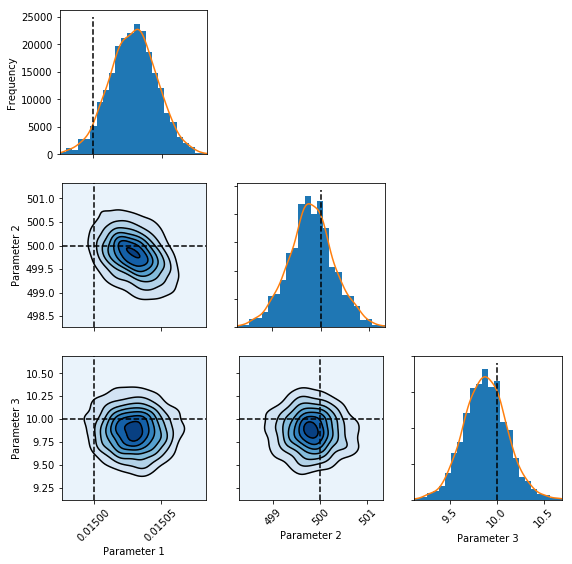

In [27]:
# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True, ref_parameters = real_parameters)

# Show graphs
plt.show()

From the plots, we see that we come close to the "true values" of the target distribution, displaying a normal distribution around such values.

# Problem 5: Time-Series Problem - Lotka-Volterra Model
We now use Slice Sampling with Doubling on a different time-series model, the [Lotka-Volterra](./toy-model-lotka-volterra.ipynb) model, describing the relationship between two interacting species, where one preys on the other.

The model has 2 states $x$ and $y$, where $x$ represents a population of prey, and $y$ represents a population of predators.
It is described by the ODEs:

$$ \frac{dx}{dt} = ax - bxy $$

and

$$ \frac{dy}{dt} = -cy + dxy $$

where $a, b, c$, and $d$ are the four model parameters.

In [28]:
model = pints.toy.LotkaVolterraModel()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 2
Parameters: 4


We can get some suggested parameters and plot some data!

[3 2 3 2]


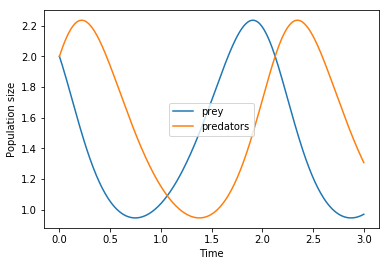

In [29]:
times = model.suggested_times()
parameters = model.suggested_parameters()
print(parameters)

plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, model.simulate(parameters, times))
plt.legend(['prey', 'predators'])
plt.show()

We can now similate some more realistic noisy values.

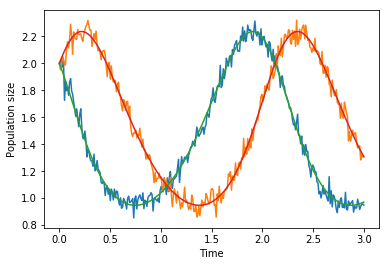

In [30]:
model.set_initial_conditions([2, 2])
values = model.simulate(parameters, times)
sigma = 0.05
noisy_values = values + np.random.normal(0, sigma, values.shape)

plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, noisy_values)
plt.plot(times, values)
plt.show()

And set up and run an MCMC routine using Slice Sampling with Doubling:

In [31]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 1, 1], [6, 6, 6, 6])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[1.5, 1, 2, 3]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0, method = pints.SliceDoublingMCMC)
mcmc.set_max_iterations(2000)
mcmc.set_log_interval(200)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     243     0:00.2
2     525     0:00.4
3     777     0:00.6
200   25713   0:24.0
400   51354   0:47.6
600   76821   1:09.9
800   102546   1:32.8
1000  128283   1:56.4
1200  153924   2:19.7
1400  179304   2:42.5
1600  204606   3:04.9
1800  230076   3:28.1
2000  254414   3:50.4
Halting: Maximum number of iterations (2000) reached.
Done!


We can now check the chains convergence by using the R-hat criterion and Pints' trace tool.

R-hat:
[1.0240553571904862, 1.0145582759262064, 1.0238960291700752, 1.0193480742292973]


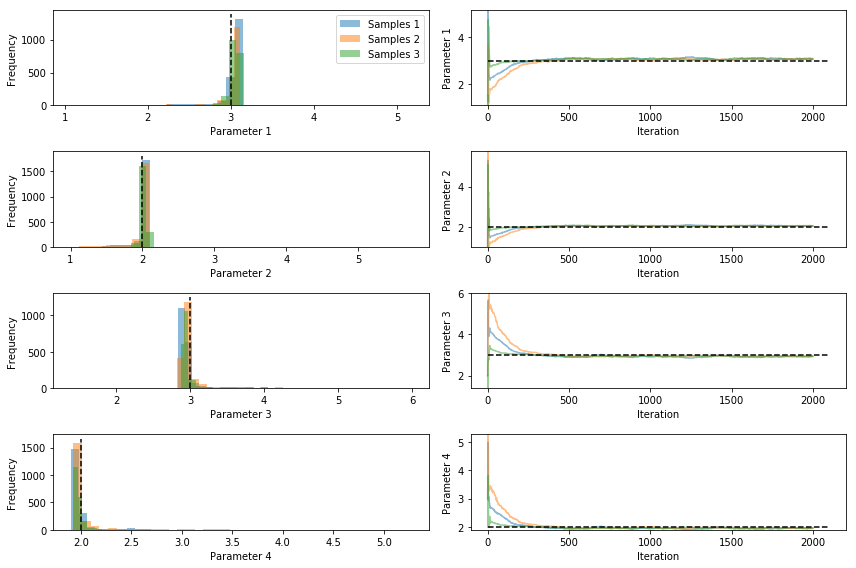

In [42]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

import pints.plot
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

From the plots, we can see that the chains convergence to the true target parameters after approximately 500 MCMC steps.

We can also compare the predictions with these values to what we found:

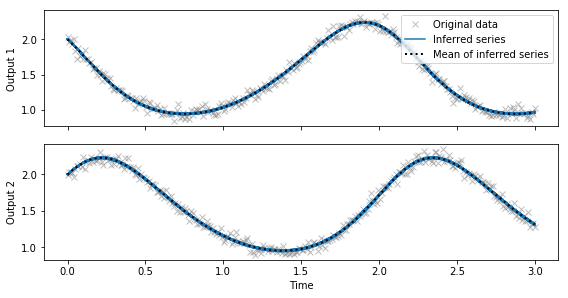

In [43]:
# Select first chain
chain1 = chains[0]

# Remove burn-in
chain1 = chain1[500:]

# Plot some predictions with these samples
pints.plot.series(chain1, problem)
plt.show()